In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import statsmodels.api as sm
from statsmodels.formula.api import ols
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Load data with the specified path
file_path = r"D:\sem 6\applied AI\green_tripdata_2024-09.parquet"
df = pd.read_parquet(file_path)
print("Dataset overview:")
print(f"Number of records: {len(df)}")
print(f"Number of columns: {len(df.columns)}")
print(df.info())

Dataset overview:
Number of records: 54440
Number of columns: 20
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54440 entries, 0 to 54439
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   VendorID               54440 non-null  int32         
 1   lpep_pickup_datetime   54440 non-null  datetime64[ns]
 2   lpep_dropoff_datetime  54440 non-null  datetime64[ns]
 3   store_and_fwd_flag     52736 non-null  object        
 4   RatecodeID             52736 non-null  float64       
 5   PULocationID           54440 non-null  int32         
 6   DOLocationID           54440 non-null  int32         
 7   passenger_count        52736 non-null  float64       
 8   trip_distance          54440 non-null  float64       
 9   fare_amount            54440 non-null  float64       
 10  extra                  54440 non-null  float64       
 11  mta_tax                54440 non-null  float64       


In [5]:
# Data preparation
# Drop unused column and calculate trip duration
df = df.drop("ehail_fee", axis=1)
df['trip_duration'] = (df['lpep_dropoff_datetime'] - df['lpep_pickup_datetime']).dt.total_seconds() / 60

In [6]:
# Extract date features
df['weekday'] = df['lpep_dropoff_datetime'].dt.day_name()
df['hourofday'] = df['lpep_dropoff_datetime'].dt.hour
df['dayofmonth'] = df['lpep_dropoff_datetime'].dt.day
df['weekend'] = df['weekday'].isin(['Saturday', 'Sunday']).astype(int)

In [7]:
# Display some basic distributions
print("\nWeekday trip distribution:")
weekday_counts = df['weekday'].value_counts()
print(weekday_counts)


Weekday trip distribution:
weekday
Monday       8939
Thursday     8244
Friday       7878
Wednesday    7855
Tuesday      7686
Sunday       7398
Saturday     6440
Name: count, dtype: int64


In [8]:
print("\nHour of day distribution:")
hour_counts = df['hourofday'].value_counts().sort_index()
print(hour_counts)


Hour of day distribution:
hourofday
0     1510
1      803
2      489
3      381
4      356
5      274
6      712
7     1709
8     2333
9     2703
10    2677
11    2552
12    2902
13    2684
14    3118
15    3584
16    3857
17    4483
18    4453
19    3542
20    2788
21    2458
22    2247
23    1825
Name: count, dtype: int64


In [9]:
# Missing values handling
print("\nMissing values before imputation:")
print(df.isnull().sum())


Missing values before imputation:
VendorID                    0
lpep_pickup_datetime        0
lpep_dropoff_datetime       0
store_and_fwd_flag       1704
RatecodeID               1704
PULocationID                0
DOLocationID                0
passenger_count          1704
trip_distance               0
fare_amount                 0
extra                       0
mta_tax                     0
tip_amount                  0
tolls_amount                0
improvement_surcharge       0
total_amount                0
payment_type             1704
trip_type                1707
congestion_surcharge     1704
trip_duration               0
weekday                     0
hourofday                   0
dayofmonth                  0
weekend                     0
dtype: int64


In [10]:
# Missing values handling
print("\nMissing values before imputation:")
print(df.isnull().sum())


Missing values before imputation:
VendorID                    0
lpep_pickup_datetime        0
lpep_dropoff_datetime       0
store_and_fwd_flag       1704
RatecodeID               1704
PULocationID                0
DOLocationID                0
passenger_count          1704
trip_distance               0
fare_amount                 0
extra                       0
mta_tax                     0
tip_amount                  0
tolls_amount                0
improvement_surcharge       0
total_amount                0
payment_type             1704
trip_type                1707
congestion_surcharge     1704
trip_duration               0
weekday                     0
hourofday                   0
dayofmonth                  0
weekend                     0
dtype: int64


In [11]:
# Numeric columns - impute with median
num_cols = ['trip_distance', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 
            'tolls_amount', 'improvement_surcharge', 'congestion_surcharge', 
            'trip_duration', 'passenger_count']

In [12]:
# Object columns - impute with mode
obj_cols = ['store_and_fwd_flag', 'RatecodeID', 'payment_type', 'trip_type']

In [13]:
# Impute missing values
for col in num_cols:
    df[col] = df[col].fillna(df[col].median())
    
for col in obj_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

print("\nMissing values after imputation:")
print(df.isnull().sum())


Missing values after imputation:
VendorID                 0
lpep_pickup_datetime     0
lpep_dropoff_datetime    0
store_and_fwd_flag       0
RatecodeID               0
PULocationID             0
DOLocationID             0
passenger_count          0
trip_distance            0
fare_amount              0
extra                    0
mta_tax                  0
tip_amount               0
tolls_amount             0
improvement_surcharge    0
total_amount             0
payment_type             0
trip_type                0
congestion_surcharge     0
trip_duration            0
weekday                  0
hourofday                0
dayofmonth               0
weekend                  0
dtype: int64


In [14]:
# Convert payment_type and trip_type to categorical if they aren't already
# Note: Based on the data info, these are actually stored as float64, so convert to int first then category
df['payment_type'] = df['payment_type'].astype(int).astype('category')
df['trip_type'] = df['trip_type'].astype(int).astype('category')
df['RatecodeID'] = df['RatecodeID'].astype(int).astype('category')

In [15]:
# Basic descriptive statistics
print("\nBasic statistics for key metrics:")
print(df[['trip_distance', 'fare_amount', 'tip_amount', 'total_amount', 'trip_duration']].describe())


Basic statistics for key metrics:
       trip_distance   fare_amount    tip_amount  total_amount  trip_duration
count   54440.000000  54440.000000  54440.000000  54440.000000   54440.000000
mean       18.412486     20.400262      2.861957     26.679474      20.716650
std      1169.915825     20.257518      3.923253     22.978650      81.429936
min         0.000000   -250.000000     -0.900000   -251.000000       0.000000
25%         1.180000     10.000000      0.000000     14.300000       7.995833
50%         1.980000     14.900000      2.125000     20.410000      12.633333
75%         3.590000     22.600000      4.040000     30.540000      19.716667
max    207968.060000    745.000000    123.800000    746.500000    1439.300000


In [16]:
# Visualizations
plt.figure(figsize=(15, 10))

<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

Text(0.5, 1.0, 'Payment Type Distribution')

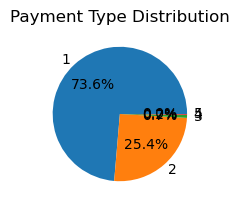

In [17]:
# Payment Type and Trip Type distribution
plt.subplot(2, 2, 1)
payment_counts = df['payment_type'].value_counts()
plt.pie(payment_counts, labels=payment_counts.index, autopct='%1.1f%%')
plt.title('Payment Type Distribution')

Text(0.5, 1.0, 'Trip Type Distribution')

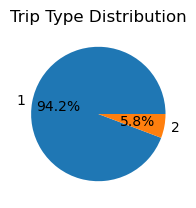

In [18]:
plt.subplot(2, 2, 2)
trip_counts = df['trip_type'].value_counts()
plt.pie(trip_counts, labels=trip_counts.index, autopct='%1.1f%%')
plt.title('Trip Type Distribution')

Text(0.5, 1.0, 'Trip Distance Distribution (capped at 20 miles)')

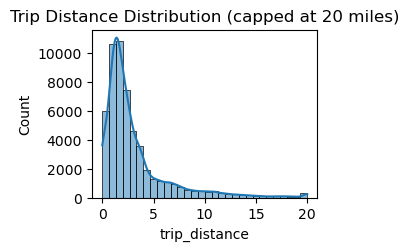

In [19]:
# Trip distance distribution
plt.subplot(2, 2, 3)
sns.histplot(df['trip_distance'].clip(upper=20), bins=30, kde=True)
plt.title('Trip Distance Distribution (capped at 20 miles)')

Text(0.5, 1.0, 'Trip Duration Distribution (capped at 60 minutes)')

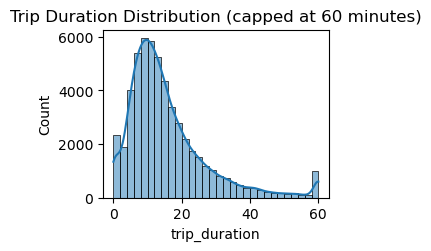

In [20]:
# Trip duration distribution
plt.subplot(2, 2, 4)
sns.histplot(df['trip_duration'].clip(upper=60), bins=30, kde=True)
plt.title('Trip Duration Distribution (capped at 60 minutes)')

In [21]:
plt.tight_layout()
plt.savefig('taxi_distribution_plots.png')
plt.close()

In [22]:
# Temporal analysis
# Average fare by hour and weekday
hourly_amounts = df.groupby('hourofday')['total_amount'].mean().reset_index()
weekday_amounts = df.groupby('weekday')['total_amount'].mean().reset_index()

In [23]:
# Create custom weekday order
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_amounts['weekday'] = pd.Categorical(weekday_amounts['weekday'], categories=weekday_order, ordered=True)
weekday_amounts = weekday_amounts.sort_values('weekday')

In [24]:
plt.figure(figsize=(15, 6))

<Figure size 1500x600 with 0 Axes>

<Figure size 1500x600 with 0 Axes>

Text(0, 0.5, 'Average Total Amount ($)')

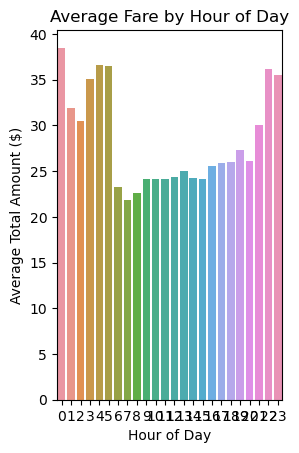

In [25]:
plt.subplot(1, 2, 1)
sns.barplot(x='hourofday', y='total_amount', data=hourly_amounts)
plt.title('Average Fare by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Average Total Amount ($)')

(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, 'Monday'),
  Text(1, 0, 'Tuesday'),
  Text(2, 0, 'Wednesday'),
  Text(3, 0, 'Thursday'),
  Text(4, 0, 'Friday'),
  Text(5, 0, 'Saturday'),
  Text(6, 0, 'Sunday')])

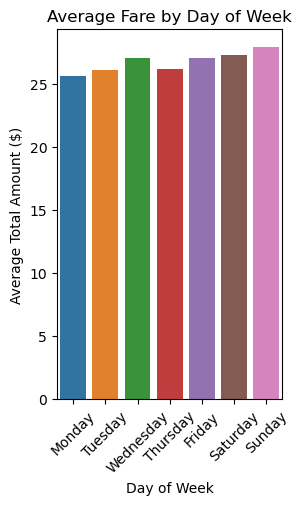

In [26]:
plt.subplot(1, 2, 2)
sns.barplot(x='weekday', y='total_amount', data=weekday_amounts)
plt.title('Average Fare by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Average Total Amount ($)')
plt.xticks(rotation=45)

In [27]:
plt.tight_layout()
plt.savefig('temporal_analysis.png')
plt.close()

In [28]:
# Tip analysis
# Create tip percentage feature
df['tip_percentage'] = (df['tip_amount'] / df['fare_amount']) * 100
df.loc[df['tip_percentage'].isin([np.inf, -np.inf]), 'tip_percentage'] = 0
df['tip_percentage'] = df['tip_percentage'].fillna(0).clip(upper=100)  # Cap at 100%

In [29]:
print("\nAverage tip percentage by payment type:")
print(df.groupby('payment_type')['tip_percentage'].mean().sort_values(ascending=False))


Average tip percentage by payment type:
payment_type
1    20.622116
3     0.461538
4     0.000000
5     0.000000
2    -0.001386
Name: tip_percentage, dtype: float64


In [30]:
print("\nAverage tip percentage by weekday:")
print(df.groupby('weekday')['tip_percentage'].mean().sort_values(ascending=False))


Average tip percentage by weekday:
weekday
Thursday     15.632548
Friday       15.406283
Monday       15.392540
Tuesday      15.223718
Wednesday    15.187513
Saturday     14.674060
Sunday       14.641204
Name: tip_percentage, dtype: float64


In [31]:
print("\nAverage tip percentage by hour of day:")
hour_tips = df.groupby('hourofday')['tip_percentage'].mean().reset_index()
print(hour_tips.sort_values('tip_percentage', ascending=False).head(5))


Average tip percentage by hour of day:
    hourofday  tip_percentage
17         17       16.890214
18         18       16.727545
19         19       16.608225
21         21       16.506302
20         20       16.410204


Text(0, 0.5, 'Average Tip (%)')

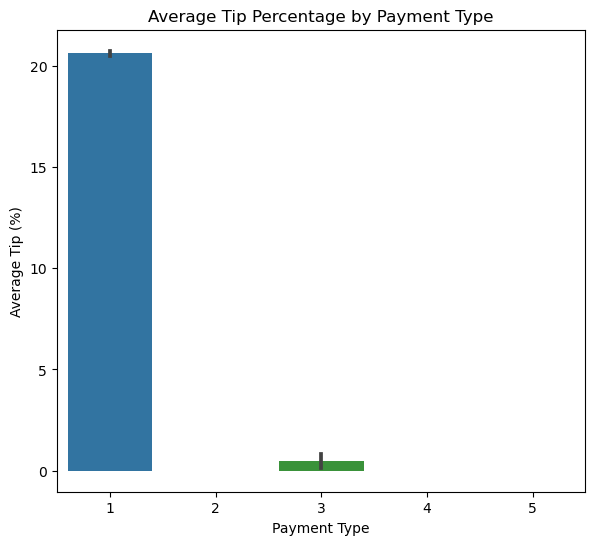

In [32]:
# Visualize tip patterns
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
sns.barplot(x='payment_type', y='tip_percentage', data=df)
plt.title('Average Tip Percentage by Payment Type')
plt.xlabel('Payment Type')
plt.ylabel('Average Tip (%)')


(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, 'Sunday'),
  Text(1, 0, 'Saturday'),
  Text(2, 0, 'Monday'),
  Text(3, 0, 'Tuesday'),
  Text(4, 0, 'Wednesday'),
  Text(5, 0, 'Thursday'),
  Text(6, 0, 'Friday')])

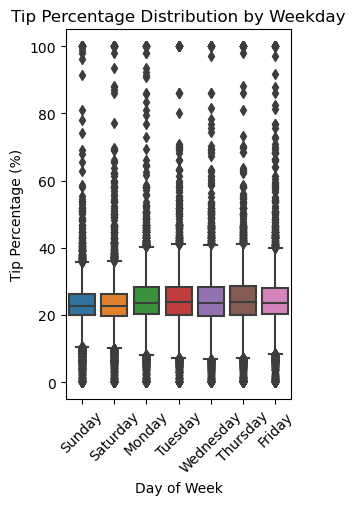

In [33]:
plt.subplot(1, 2, 2)
sns.boxplot(x='weekday', y='tip_percentage', data=df[df['tip_percentage'] > 0])
plt.title('Tip Percentage Distribution by Weekday')
plt.xlabel('Day of Week')
plt.ylabel('Tip Percentage (%)')
plt.xticks(rotation=45)

In [34]:
plt.tight_layout()
plt.savefig('tip_analysis.png')
plt.close()

In [35]:
# Statistical tests
# ANOVA test for total_amount by trip_type
print("\nANOVA test for total_amount by trip_type:")
model = ols('total_amount ~ C(trip_type)', data=df).fit()
anova_result = sm.stats.anova_lm(model, typ=2)
print(anova_result)


ANOVA test for total_amount by trip_type:
                    sum_sq       df            F  PR(>F)
C(trip_type)  3.302864e+06      1.0  7067.126643     0.0
Residual      2.544193e+07  54438.0          NaN     NaN


In [36]:
# ANOVA test for total_amount by weekday
print("\nANOVA test for total_amount by weekday:")
model = ols('total_amount ~ C(weekday)', data=df).fit()
anova_result = sm.stats.anova_lm(model, typ=2)
print(anova_result)


ANOVA test for total_amount by weekday:
                  sum_sq       df         F        PR(>F)
C(weekday)  3.033008e+04      6.0  9.582612  1.469143e-10
Residual    2.871446e+07  54433.0       NaN           NaN


In [37]:
# Chi-square test for association between trip_type and payment_type
contingency_table = pd.crosstab(df['trip_type'], df['payment_type'])
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
print(f"\nChi-square test for association between trip_type and payment_type:")
print(f"Chi2: {chi2:.4f}, p-value: {p:.8f}")


Chi-square test for association between trip_type and payment_type:
Chi2: 266.3824, p-value: 0.00000000


In [38]:
# Correlation analysis
# Select numerical columns for correlation
correlation_cols = ['trip_distance', 'trip_duration', 'fare_amount', 'tip_amount', 
                    'total_amount', 'passenger_count', 'weekend']

In [39]:
corr_matrix = df[correlation_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Correlation Matrix')
plt.tight_layout()
plt.savefig('correlation_matrix.png')
plt.close()

In [40]:
# Prepare data for modeling
# Create dummy variables
df_encoded = pd.get_dummies(df, columns=['store_and_fwd_flag', 'RatecodeID', 
                                         'payment_type', 'trip_type', 
                                         'weekday'], drop_first=True)

In [41]:
# Select features and target
X = df_encoded.drop(['lpep_pickup_datetime', 'lpep_dropoff_datetime', 
                    'PULocationID', 'DOLocationID', 'total_amount',
                    'tip_percentage'], axis=1, errors='ignore')
y = df_encoded['total_amount']

In [42]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\nTraining set: {X_train.shape}")
print(f"Test set: {X_test.shape}")


Training set: (43552, 31)
Test set: (10888, 31)


In [ ]:
# Build and evaluate models
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(max_depth=10, random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=15, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=42)
}

In [49]:
# Calculate metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

results.append({
    'Model': name,
    'RMSE': rmse,
    'MAE': mae,
    'R² Score': r2
})

print(f"{name}:")
print(f"  RMSE: ${rmse:.2f}")
print(f"  MAE: ${mae:.2f}")
print(f"  R² Score: {r2:.4f}")

Gradient Boosting:
  RMSE: $1.09
  MAE: $0.37
  R² Score: 0.9979


In [50]:
# Feature importance for best model (Random Forest)
best_model = models['Random Forest']
features = X.columns
importances = best_model.feature_importances_
indices = np.argsort(importances)[-10:] 
# Get top 10 features

In [51]:
plt.figure(figsize=(12, 8))
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.title('Top 10 Important Features for Predicting Fare Amount')
plt.tight_layout()
plt.savefig('feature_importance.png')
plt.close()

In [52]:
# Additional analysis - trip distance vs. fare amount
plt.figure(figsize=(10, 6))
sns.scatterplot(x='trip_distance', y='fare_amount', data=df.sample(1000), alpha=0.6, s=50)
plt.title('Trip Distance vs. Fare Amount')
plt.xlabel('Trip Distance (miles)')
plt.ylabel('Fare Amount ($)')
plt.grid(True, alpha=0.3)
plt.savefig('distance_vs_fare.png')
plt.close()

In [53]:
# Create a summary DataFrame of model results
results_df = pd.DataFrame(results)
print("\nModel Comparison:")
print(results_df.to_string(index=False))


Model Comparison:
            Model     RMSE      MAE  R² Score
Linear Regression 0.455621 0.275542  0.999630
    Decision Tree 2.902827 0.937966  0.984992
    Random Forest 1.131608 0.239728  0.997719
Gradient Boosting 1.088846 0.368751  0.997888
Linear Regression 0.455621 0.275542  0.999630
    Decision Tree 2.902827 0.937966  0.984992
    Random Forest 1.131608 0.239728  0.997719
Gradient Boosting 1.088846 0.368751  0.997888
Gradient Boosting 1.088846 0.368751  0.997888


In [54]:
# Create a new visualization showing VendorID comparison
plt.figure(figsize=(15, 6))

<Figure size 1500x600 with 0 Axes>

<Figure size 1500x600 with 0 Axes>

Text(0, 0.5, 'Trip Distance (miles)')

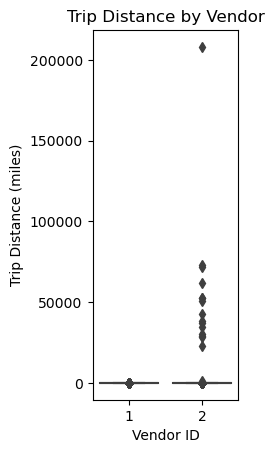

In [55]:
# Compare trip distance by vendor
plt.subplot(1, 3, 1)
sns.boxplot(x='VendorID', y='trip_distance', data=df)
plt.title('Trip Distance by Vendor')
plt.xlabel('Vendor ID')
plt.ylabel('Trip Distance (miles)')

Text(0, 0.5, 'Fare Amount ($)')

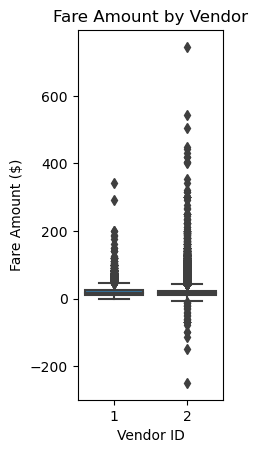

In [56]:
# Compare fare by vendor
plt.subplot(1, 3, 2)
sns.boxplot(x='VendorID', y='fare_amount', data=df)
plt.title('Fare Amount by Vendor')
plt.xlabel('Vendor ID')
plt.ylabel('Fare Amount ($)')

Text(0, 0.5, 'Tip Percentage (%)')

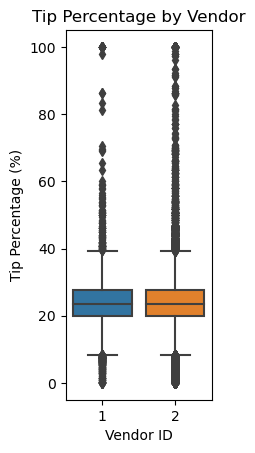

In [57]:
# Compare tip by vendor
plt.subplot(1, 3, 3)
sns.boxplot(x='VendorID', y='tip_percentage', data=df[df['tip_percentage'] > 0])
plt.title('Tip Percentage by Vendor')
plt.xlabel('Vendor ID')
plt.ylabel('Tip Percentage (%)')

In [58]:
plt.tight_layout()
plt.savefig('vendor_comparison.png')
plt.close()

In [59]:
# Add map visualization - location-based analysis (mock visualization as we don't have actual location data)
# This would typically use actual location data, but we're creating a mock visualization
plt.figure(figsize=(10, 8))
unique_locations = df['PULocationID'].unique()
location_counts = df['PULocationID'].value_counts().sort_index()

<Figure size 1000x800 with 0 Axes>

In [61]:
plt.bar(range(len(location_counts)), location_counts.values)
plt.title('Trip Count by Pickup Location ID')
plt.xlabel('Pickup Location ID')
plt.ylabel('Number of Trips')
plt.xticks([])  # Hide x-axis ticks as there would be too many
plt.savefig('location_analysis.png')
plt.close()

print("\nAnalysis complete (september 2024 by PRAGNYA REDDY - Sap id : 70572200054 !")


Analysis complete (september 2024 by PRAGNYA REDDY - Sap id : 70572200054 !
